In [1]:
from src import attributes as a
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Global Variables
stock_name = 'tsla' # ticker symbol
train = 0 # 1 for train, 0 for pass
days_ahead = 1 # for predicting 1, 3, or 5 days ahead
days_back = -1 # -1 for current data point, -2 for two days ago, etc...
cv = 5 # number of cross validation folds
model_name = 'Random Forest Classifier' # for display on charts, not a tuning parameter

In [3]:
import pandas
print(pandas.__version__)

1.3.5


In [4]:
# Extract, Transform, Load, and Train Test Split
# Dictionary of IPO Dates
start_dates = {'a': '11/15/1999' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'aapl': '12/12/1980' # Updated 11/8/21 1D, 3D, 5D ahead
               #, 'acy': '01/18/1998' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'adbe': '08/11/1986' # Updated 11/8/21 1D, 3D, 5D ahead
               #, 'alb': '02/21/1994' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'amat': '03/16/1980' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'amd': '03/17/1980' # Updated 11/23/21 1D, 3D, 5D ahead
               , 'amgn': '06/13/1983' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'amzn': '05/12/1997' # Updated 11/07/21 1D, 3D, 5D ahead
               , 'baba': '09/15/2014' # Updated 11/13/21 1D, 3D, 5D ahead
               , 'ba': '01/02/1962' # Updated 05/23/21 1D, 3D, 5D ahead
               , 'bac': '02/19/1973' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'bby': '04/15/1985' # Updated 11/19/21 1D, 3D, 5D ahead
               #, 'bpmc': '04/27/2015' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'brk-b': '05/06/1996' # Updated 4/25/23 1D, 3D, 5D ahead
               , 'crm': '06/23/2004' # Updated 11/13/21 1D, 3D, 5D ahead
               #, 'crsp': '10/16/2016' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'cost': '07/07/1986' # Updated 11/23/21 1D, 3D, 5D ahead
               #, 'dis': '10/27/2014' # Updatd 11/5/21 1D, 3D, 5D ahead
               #, 'dq': '10/04/2010' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'esgv': '09/16/2018' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'fslr': '11/12/2006' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'ge': '01/02/1962' # Updated 5/23/23 1D, 3D, 5D ahead
               , 'goog': '08/16/2004' # Updated 11/8/21 1D, 3D, 5D ahead
               , 'ibm': '01/02/1962' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'intc': '03/16/1980' # Updated 11/13/21 1D, 3D, 5D ahead
               , 'iyw': '05/15/2000' # Updated 11/21/21 1D, 3D, 5D ahead
               , 'll': '11/05/2007' # Updated 11/22/21 1D, 3D, 5D ahead
               , 'lng': '04/04/1994' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'ma': '05/21/2006' # Updated 4/26/21 1D, 3D, 5D ahead
               # , 'mdb': '10/15/2017' # Updated 11/21/21 1D, 3D, 5D ahead
               , 'msft': '03/10/1986' # Updated 11/8/21 1D, 3D, 5D ahead
               , 'mu': '05/28/1984' # Updated 11/20/21 1D, 3D, 5D ahead
               #, 'nee': '02/19/1973' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'nio': '09/10/2018' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'nvda': '01/22/1999' # Updated 11/17/21 1D, 3D, 5D ahead
               #, 'pacb': '10/25/2010' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'pypl': '07/05/2015' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'qgen': '06/24/1996' # Updated 4/26/21 1D, 3D, 5D ahead
               #, 'run': '08/02/2015' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'okta': '04/03/2017' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'orcl': '03/10/1986' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'qcom': '12/09/1991' # Updated 11/20/21 1D, 3D, 5D ahead
               , 'qqq': '03/08/1999' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'srpt': '06/02/1997' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'tgt': '02/19/1973' # Updated 11/22/21 1D, 3D, 5D ahead
               #, 'tpic': '07/17/2016' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'tsla': '06/29/2010' # Updated 11/07/21 1D, 3D, 5D ahead
               , 'tsm': '10/06/1997' # Updated 11/20/21 1D, 3D, 5D ahead
               , 'v': '03/16/2008' # Updated 11/22/21 1D, 3D, 5D ahead
               , 'vbiv': '09/04/2002' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'vbr': '01/26/2004' # Updated 11/20/21 1D, 3D, 5D ahead
               #, 'viov': '09/06/2010' # Updated 4/26/21 1D, 3D, 5D ahead
               , 'vgt': '01/26/2004' # Updated 11/07/21 1D, 3D, 5D ahead
               , 'wmt': '11/10/2014' # Updated 11/16/21 1D, 3D, 5D ahead
               , 'xli': '12/21/1998' # Updated 11/21/21 1D, 3D, 5D ahead
               , 'xlk': '12/21/1998' # Updated 5/23/23 1D, 3D, 5D ahead
              }

### Get Data...

In [5]:
from datetime import date, datetime
today = date.today()
print("Today's date:", today)
a.get_tables(start_dates) # commented out for 2021-12-19, data already downloaded for weekend
print('Table Updates Complete')
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time: ", current_time)

Today's date: 2024-01-28
Table Updates Complete
Current Time:  02:21:25


In [6]:
# Load RandomForextClassifier Model
# rfc_model, y_pred, y_probs = a.rfc(X_train, X_test, y_train, stock_name, days_ahead)

In [7]:
# ROC Curve
# a.roc_plot(y_test, y_probs, stock_name, model_name)

In [8]:
# Precision Recall Curve
# a.prec_recall(y_test, y_probs, stock_name, model_name)

In [9]:
# Confusion Matrix
# a.confusion_matrix(rfc_model, X_test, y_test, stock_name)

In [10]:
# Cross Validation
# a.cross_validation(rfc_model
#                    , stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']]
#                    , stock_df['direction']
#                    , cv = 5
#                   )

### Prediction...

In [11]:
# Prediction, use last day of data
# stock_df.iloc[-1]

In [12]:
# import numpy as np
# last = stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']].iloc[-days_back]
# last

In [13]:
# stock_df['adj'].describe()

In [14]:
# if rfc_model.predict(np.array(last).reshape(1, -1))[0] == 1:
#     print(f'Buy {stock_name} {days_ahead} day(s) ahead')
# else:
#     print(f'Sell or hold {stock_name} {days_ahead} day(s) ahead')

### Strategy Returns...

In [15]:
# returns on strategy column
# stock_df['prediction'] = rfc_model.predict(stock_df[['oc', 'hl', '5stdev_adj', '5sma_adj']])
# stock_df['returns'] = stock_df['adj'].shift(-1, fill_value = stock_df['adj'].median()) * stock_df['prediction']

In [16]:
# stock_df.tail(5)

In [17]:
# Don't trade every day!
# import matplotlib.pyplot as plt
# test_length = len(y_test)
# (stock_df['returns'][-test_length:] + 1).cumprod().plot()
# plt.title(f'{stock_name} Expected Returns %');

In [18]:
# Model returns if bought on predictions of 1
# returns_on_ones = []
# for idx in range(-test_length, 0):
#     if stock_df['prediction'][idx] == 1:
#         returns_on_ones.append(1 + stock_df['returns'][idx])

# returns = 1
# for x in returns_on_ones:
#     returns *= x
# returns

In [19]:
# multiple times original investment, not bad but...

In [20]:
# If purchased in 2012 and left it until now
# test_idx = int(len(stock_df)*0.75)
# (stock_df['Close'][-1] - stock_df['Close'][-test_idx]) / stock_df['Close'][-test_idx]

In [21]:
# Buy and hold strategy beats RandomForestClassifier in this study

# Special thanks to Shagufta Tahsildar at https://blog.quantinsti.com/random-forest-algorithm-in-python/

### Training

Training is done once a week on Saturday and Sunday

In [22]:
len(start_dates)

45

In [23]:
import itertools as itr
start_dates1 = dict(itr.islice(start_dates.items(), 0, 15))
start_dates1

{'a': '11/15/1999',
 'aapl': '12/12/1980',
 'adbe': '08/11/1986',
 'amat': '03/16/1980',
 'amd': '03/17/1980',
 'amgn': '06/13/1983',
 'amzn': '05/12/1997',
 'baba': '09/15/2014',
 'ba': '01/02/1962',
 'bac': '02/19/1973',
 'bby': '04/15/1985',
 'brk-b': '05/06/1996',
 'crm': '06/23/2004',
 'cost': '07/07/1986',
 'esgv': '09/16/2018'}

In [24]:
start_dates2 = dict(itr.islice(start_dates.items(), 15, 30))
start_dates2

{'fslr': '11/12/2006',
 'ge': '01/02/1962',
 'goog': '08/16/2004',
 'ibm': '01/02/1962',
 'intc': '03/16/1980',
 'iyw': '05/15/2000',
 'll': '11/05/2007',
 'lng': '04/04/1994',
 'ma': '05/21/2006',
 'msft': '03/10/1986',
 'mu': '05/28/1984',
 'nio': '09/10/2018',
 'nvda': '01/22/1999',
 'pypl': '07/05/2015',
 'qgen': '06/24/1996'}

In [25]:
start_dates3 = dict(itr.islice(start_dates.items(), 30, 45+1))
start_dates3

{'okta': '04/03/2017',
 'orcl': '03/10/1986',
 'qcom': '12/09/1991',
 'qqq': '03/08/1999',
 'srpt': '06/02/1997',
 'tgt': '02/19/1973',
 'tsla': '06/29/2010',
 'tsm': '10/06/1997',
 'v': '03/16/2008',
 'vbiv': '09/04/2002',
 'vbr': '01/26/2004',
 'vgt': '01/26/2004',
 'wmt': '11/10/2014',
 'xli': '12/21/1998',
 'xlk': '12/21/1998'}

In [26]:
# from datetime import datetime

# now = datetime.now()

# current_time = now.strftime("%H:%M:%S")
# print("Gridsearch Start Date: ", today)
# print("Current Time: ", current_time)

#Train 15 at a time!
# stocks = [x for x in start_dates1]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# Next on training for Saturday 4/17/2021
# stocks = [x for x in start_dates2]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# Next on training for Saturday 4/17/2021
# stocks = [x for x in start_dates3]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# # Train all, takes 15+ hours
# stocks = [x for x in start_dates]
# days_ahead = [1, 3, 5]
# cv = 5
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         a.rfc_GridSearch(X_train, y_train, stock, days, cv)
# len(stocks)

# Train desired stocks...takes less time (4 will take 15.5 hours, each stock is roughly 2.5-4 hours to train)
# 3 will take 7.5 hours, roughly 2.5 hours per stock trained
# to train: ['cost']

# import timeit 
# stocks = ['xli', 'ba', 'ge'] # updated 2023-05-23 (3:48pm - 12:47am ~9hours)
# days_ahead = [1, 3, 5] 
# cv = 2 # was 5 
# for stock in stocks:
#     for days in days_ahead:
#         X_train, X_test, y_train, y_test, stock_df = a.data(stock, start_dates[stock], days)
#         %timeit a.rfc_GridSearch(X_train, y_train, stock, days, cv)

# now = datetime.now()

# current_time = now.strftime("%H:%M:%S")
# print("Gridsearch End Date: ", today)
# print("Current Time: ", current_time)

### Display All Results

**NOTE:** Returns include buying ups and selling downs

In [27]:
from datetime import date, datetime
today = date.today()
print("Today's date:", today)
now = datetime.now()
current_time = now.strftime("%H:%M:%S")
print("Current Time: ", current_time)

Today's date: 2024-01-28
Current Time:  02:21:26


Buy amat 1 day(s) ahead
Model Returns (x 100 for %): 6.0877
Stock Returns (x 100 for %): 1447.6471


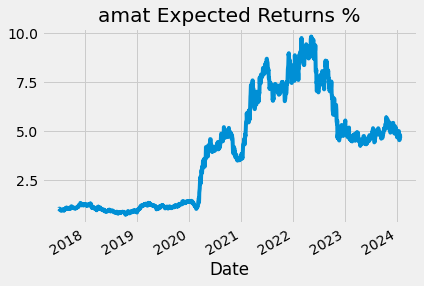

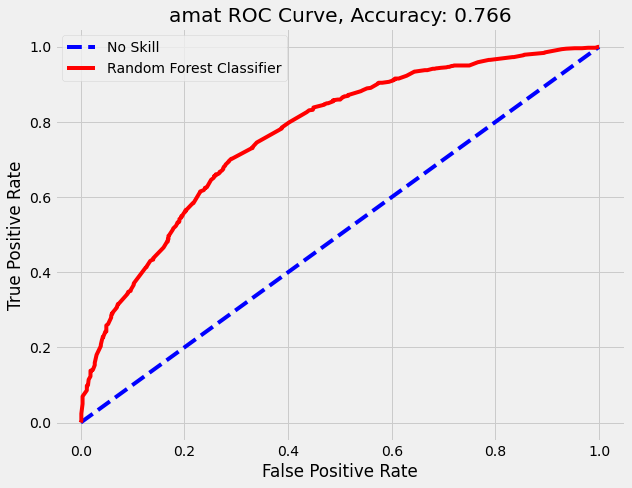

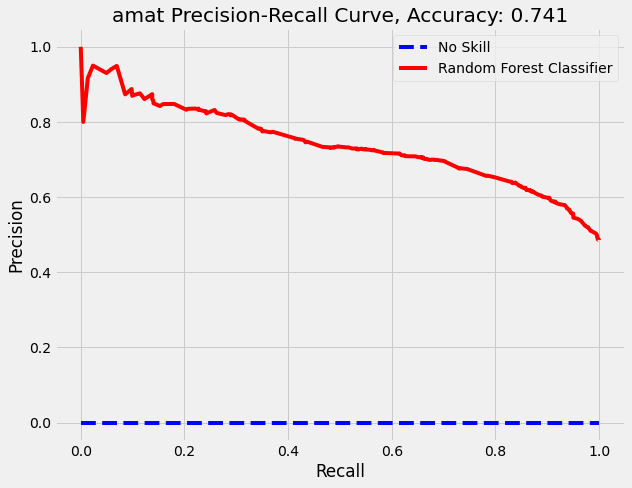

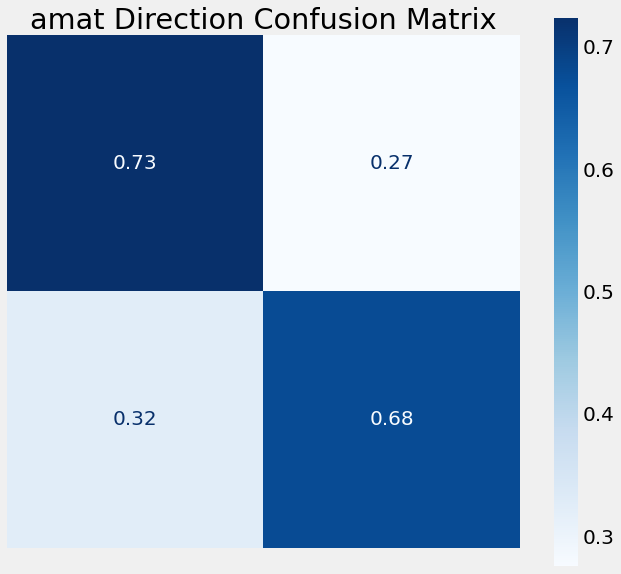

In [28]:
stock_name = 'amat'
a.all_func(stock_name
           , start_dates[stock_name]
           , days_ahead = 1
           , model_name = model_name
           , days_back = 1
          )
# chart shows if traded every day up or down

### Data Frame of Predictions 1 3 5 Days

**NOTE:** Returns are for buys only.

In [29]:
print("Today's date:", today)
print("Current Time =", current_time)

Today's date: 2024-01-28
Current Time = 02:21:26


In [30]:
summary_df = a.pred_summary_df(start_dates1, stocks = [x for x in start_dates1], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,a,Buy,1.4491,Buy,1.2703,Buy,1.2507,9.4907
1,aapl,Buy,2.9069,Buy,3.1384,Buy,2.4681,673.1265
2,adbe,Buy,2.6656,Buy,3.0774,Buy,2.4950,238.4079
3,amat,Buy,7.4733,Buy,6.9908,Buy,6.7752,1447.6471
4,amd,Hold or Sell,3.8792,Hold or Sell,8.9661,Hold or Sell,7.0412,23.6609
5,amgn,Hold or Sell,1.3823,Hold or Sell,1.5429,Hold or Sell,1.1937,530.3374
6,amzn,Hold or Sell,1.4415,Buy,1.3556,Hold or Sell,1.4491,213.1588
7,baba,Hold or Sell,1.1512,Hold or Sell,1.2442,Hold or Sell,1.1864,0.0134
8,ba,Hold or Sell,1.0518,Hold or Sell,0.8741,Hold or Sell,0.9414,1054.1250
9,bac,Hold or Sell,1.4839,Hold or Sell,1.1912,Hold or Sell,2.3064,58.5777


In [31]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(1.4415, 1.3556, 1.3603, 83.7389)

In [32]:
summary_df = a.pred_summary_df(start_dates2, stocks = [x for x in start_dates2], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,fslr,Buy,1.0776,Buy,1.0809,Buy,1.0950,0.0183
1,ge,Hold or Sell,0.6569,Hold or Sell,0.6183,Hold or Sell,0.6698,82.0498
2,goog,Hold or Sell,1.6703,Hold or Sell,1.5508,Hold or Sell,1.5675,11.4101
3,ibm,Buy,1.5825,Buy,1.4991,Buy,1.2401,55.4262
4,intc,Buy,3.7136,Buy,3.1273,Buy,3.4212,182.1157
5,iyw,Buy,1.4900,Buy,1.5337,Buy,1.2845,10.5375
6,ll,Buy,0.2384,Buy,0.1906,Buy,0.3286,-0.9052
7,lng,Hold or Sell,2.7216,Hold or Sell,1.9669,Hold or Sell,2.1313,170.6477
8,ma,Hold or Sell,1.0982,Hold or Sell,1.0379,Hold or Sell,1.0768,29.5245
9,msft,Buy,5.7118,Buy,5.4103,Buy,5.1571,306.3594


In [33]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(1.49, 1.4991, 1.2845, 29.5245)

In [34]:
summary_df = a.pred_summary_df(start_dates3, stocks = [x for x in start_dates3], days_back = 1)
summary_df

,stock,1_Day_Pred,1_Day_Model_Return,3_Day_Pred,3_Day_Model_Return,5_Day_Pred,5_Day_Model_Return,Actual_Returns
0,okta,Hold or Sell,1.4297,Hold or Sell,1.2661,Hold or Sell,1.1446,0.6786
1,orcl,Hold or Sell,2.6733,Buy,2.4228,Hold or Sell,2.8188,458.5805
2,qcom,Buy,1.7977,Buy,1.7465,Buy,2.8074,101.1487
3,qqq,Buy,1.6613,Buy,1.8515,Buy,1.7078,19.3649
4,srpt,Buy,0.6532,Buy,1.6151,Buy,1.1957,1.1164
5,tgt,Buy,1.4704,Hold or Sell,2.3810,Buy,1.9212,353.9032
6,tsla,Buy,0.2683,Buy,0.2664,Buy,0.4261,96.2320
7,tsm,Hold or Sell,3.3235,Hold or Sell,3.0063,Hold or Sell,2.9711,28.9652
8,v,Hold or Sell,1.1628,Hold or Sell,1.2321,Hold or Sell,0.9950,15.9554
9,vbiv,Buy,0.0383,Buy,0.0206,Hold or Sell,0.0957,-0.9989


In [35]:
summary_df['1_Day_Model_Return'].median(), summary_df['3_Day_Model_Return'].median(), summary_df['5_Day_Model_Return'].median(), summary_df['Actual_Returns'].median()

(1.3111, 1.3519, 1.314, 17.3947)